##Imports:

In [ ]:
!pip install quandl
!pip install fredapi

In [ ]:
# Imports

import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred

import seaborn as sns
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

##Importing and Transforming Datasets

In [ ]:
# Connect to quandl account & read in datasets

quandl.ApiConfig.api_key = 'TiurezUkFLzhzNn89Scu'

# Define the dataset code for US Treasury bond yields
dataset_code = "USTREASURY/YIELD"  # Example: US Treasury bond yields

# Retrieve the dataset
treasury_yield_data = quandl.get(dataset_code)

# Create different subsets of treasuries

# 3-Month T-bill
three_month = treasury_yield_data.reset_index()[['Date', '3 MO']]
three_month.set_index('Date', inplace=True)

# 5-Year T-note
five_year = treasury_yield_data.reset_index()[['Date', '5 YR']]
five_year.set_index('Date', inplace=True)

# 10-Year T-note (What we are using for this project)
ten_year = treasury_yield_data.reset_index()[['Date', '10 YR']]
ten_year.set_index('Date', inplace=True)

# 30-Year T-bond
thirty_year = treasury_yield_data.reset_index()[['Date', '30 YR']]
thirty_year.set_index('Date', inplace=True)

print(three_month.head())
print(five_year.head())
print(ten_year.head())
print(thirty_year.head())


            3 MO
Date            
1990-01-02  7.83
1990-01-03  7.89
1990-01-04  7.84
1990-01-05  7.79
1990-01-08  7.79
            5 YR
Date            
1990-01-02  7.87
1990-01-03  7.92
1990-01-04  7.91
1990-01-05  7.92
1990-01-08  7.92
            10 YR
Date             
1990-01-02   7.94
1990-01-03   7.99
1990-01-04   7.98
1990-01-05   7.99
1990-01-08   8.02
            30 YR
Date             
1990-01-02   8.00
1990-01-03   8.04
1990-01-04   8.04
1990-01-05   8.06
1990-01-08   8.09


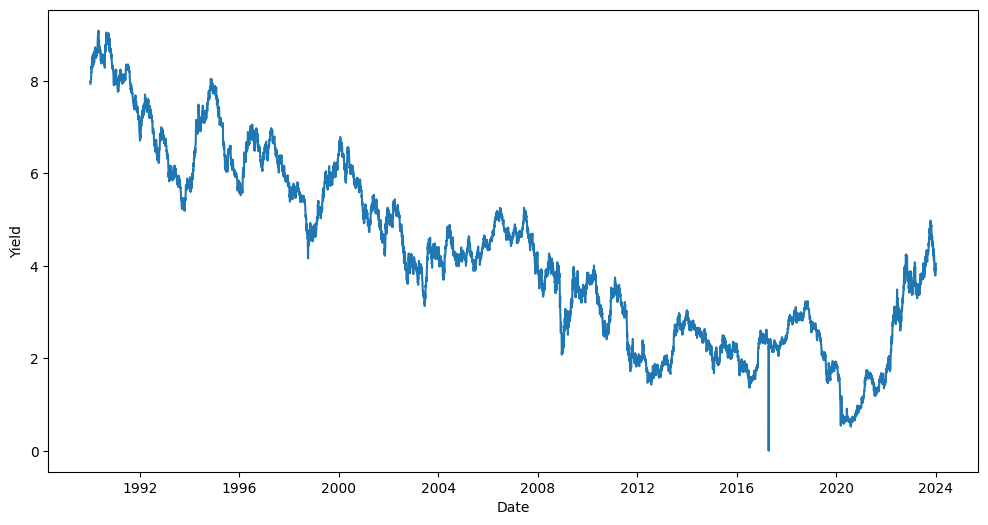

In [ ]:
# Cleaning up dataset for monthly values only

df = ten_year  # Change for each treasury

df_resampled = df.resample('M').last()

df_resampled.ffill(inplace=True)
df_resampled.dropna(inplace=True)

# Plot yield values
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Yield')
plt.plot(df)


In [ ]:
# Load and clean up GDP, unemployment, and inflation measurements

fred = Fred(api_key='faaf92070c030324ca254a27d232d4c3')

gdp = fred.get_series('GDP')
unemployment = fred.get_series('UNRATE')
inflation = fred.get_series('CPIAUCSL')

# Convert each measurement to monthly
gdp.index = pd.to_datetime(gdp.index)
gdp = gdp.resample('M').last()

unemployment.index = pd.to_datetime(unemployment.index)
unemployment = unemployment.resample('M').last()

inflation.index = pd.to_datetime(inflation.index)
inflation = inflation.resample('M').last()

# Combine all measurements into one dataframe
df_measures = pd.concat([gdp, unemployment, inflation], axis=1)
df_measures.columns = ['GDP', 'Unemployment', 'Inflation']
df_measures.ffill(inplace=True)

# Change starting date to line up with the treasuries starting dates (1990)
df_measures = df_measures.loc['1990-01-01':]

print(df_measures.head())

                 GDP  Unemployment  Inflation
1990-01-31  5872.701           5.4      127.5
1990-02-28  5872.701           5.3      128.0
1990-03-31  5872.701           5.2      128.6
1990-04-30  5960.028           5.4      128.9
1990-05-31  5960.028           5.4      129.1


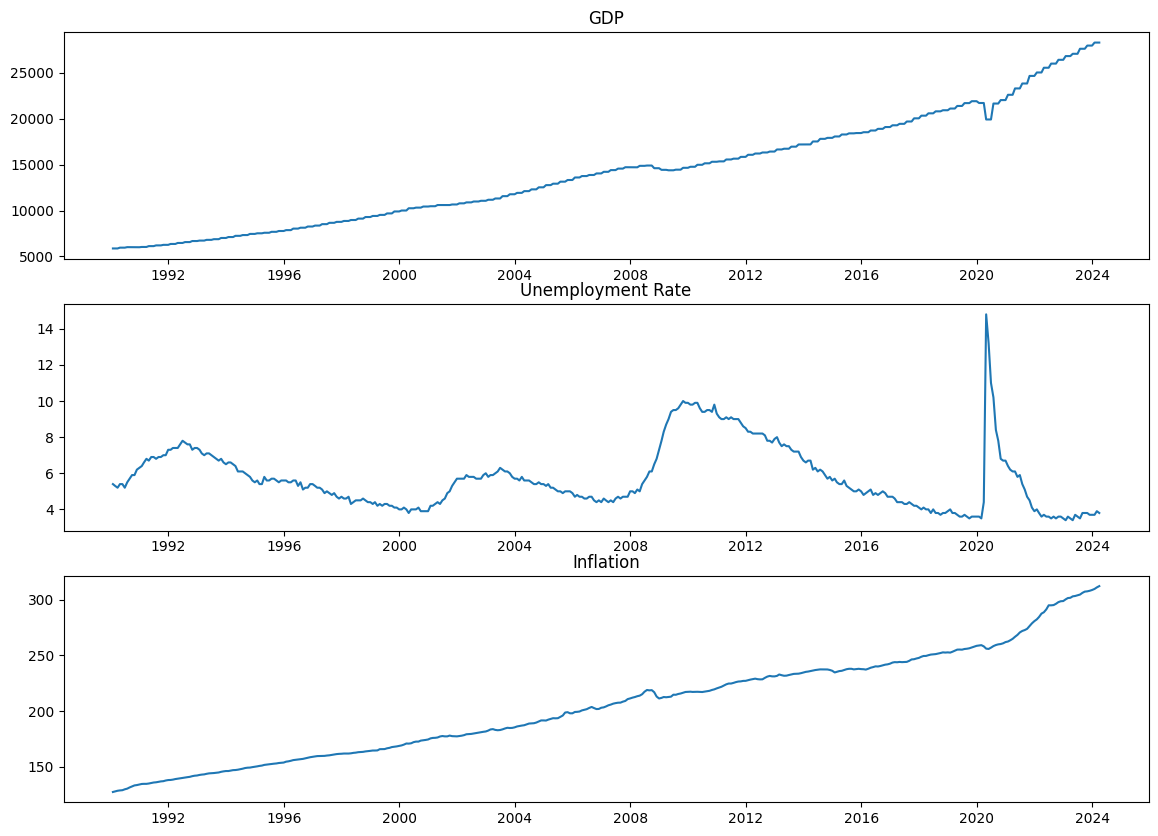

In [ ]:
# Plots of each measure

plt.figure(figsize=(14,10))

plt.subplot(311)
plt.title('GDP')
plt.plot(df_measures['GDP'])

plt.subplot(312)
plt.title('Unemployment Rate')
plt.plot(df_measures['Unemployment'])

plt.subplot(313)
plt.title('Inflation')
plt.plot(df_measures['Inflation'])

plt.show()

            10 YR       GDP  Unemployment  Inflation
1990-01-31   8.43  5872.701           5.4      127.5
1990-02-28   8.51  5872.701           5.3      128.0
1990-03-31   8.65  5872.701           5.2      128.6
1990-04-30   9.04  5960.028           5.4      128.9
1990-05-31   8.60  5960.028           5.4      129.1
            10 YR        GDP  Unemployment  Inflation
2023-08-31   4.09  27610.128           3.8    306.187
2023-09-30   4.59  27610.128           3.8    307.288
2023-10-31   4.88  27956.998           3.8    307.531
2023-11-30   4.37  27956.998           3.7    308.024
2023-12-31   3.88  27956.998           3.7    308.742


<Axes: >

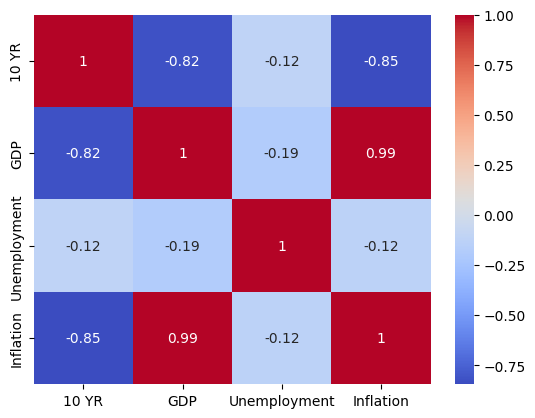

In [ ]:
# Combine bond yields with measurements from fredapi and quandl
df_resampled.name = 'Yield'
df_combined = pd.concat([df_resampled, df_measures], axis=1)

# Transform data so that we have full years (eliminate extra months)
months_past_year = len(df_combined) % 12
df_combined = df_combined[:-months_past_year]

# Print first few rows of the combined data frame
print(df_combined.head())
print(df_combined.tail())

# Create correlation matrix to see initial correlations
correlation_matrix = df_combined.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')


1 = Positive correlation

-1 = Negative correlation

0 = No linear relationship




##Preparing X and y sets

In [ ]:
# Transforming data into an X set and Y set for training and testing
# X set has the following features: Yield, GDP, Unemployment, and Inflation for the first 11 months
# Y set: Yield value for the 12th month

X_set = []
Y_set = []

for index, row in df_combined.iterrows():
   if index.month == 12:
    Y_set.append(row['10 YR'])

for i in range(0, len(df_combined), 12):
    year = df_combined.iloc[i:i+11]
    X_set.append(year)


# Convert to NumPy arrays for optimal compatibility with algorithms
X_set = np.array(X_set)
Y_set = np.array(Y_set)

# Convert X_set from 3-D to 2-D for compatibility
X_set_2d = X_set.reshape(len(X_set), -1)

In [ ]:
# Creating a dataset of just Yield, GDP, Unemployment
X_Yield_GDP_Unemployment = X_set[:, :, :-1]
X_Yield_GDP_Unemployment_2d = X_Yield_GDP_Unemployment.reshape(len(X_Yield_GDP_Unemployment) , -1)

# Creating a dataset of just Yield, Unemployment, and Inflation
X_Yield_Unemployment_Inflation = X_set[:, :, [0, 2, 3]]
X_Yield_Unemployment_Inflation_2d = X_Yield_Unemployment_Inflation.reshape(len(X_Yield_Unemployment_Inflation) , -1)

# Creating a dataset of just GDP, Unemployment, and Inflation
X_GDP_Unemployment_Inflation = X_set[:, :, 1:]
X_GDP_Unemployment_Inflation_2d = X_GDP_Unemployment_Inflation.reshape(len(X_GDP_Unemployment_Inflation) , -1)

# Creating a dataset of just Yield
X_Yield = X_set[:, :, 0].reshape(-1, 11, 1)
X_Yield_2d = X_Yield.reshape(len(X_Yield) , -1)

# Creating a dataset of just GDP
X_GDP = X_set[:, :, 1].reshape(-1, 11, 1)
X_GDP_2d = X_GDP.reshape(len(X_GDP) , -1)

# Creating a dataset of just Unemployment
X_Unemployment = X_set[:, :, 2].reshape(-1, 11, 1)
X_Unemployment_2d = X_Unemployment.reshape(len(X_Unemployment) , -1)

# Creating a dataset of just Inflation
X_Inflation = X_set[:, :, 3].reshape(-1, 11, 1)
X_Inflation_2d = X_Inflation.reshape(len(X_Inflation) , -1)

##Model 1: Linear Regression

In [ ]:
# 4 Features
# Uses the Yield of Return, GDP, Unemployment, and Inflation of the last 11 months to predict the yield of return of the 12th month for every year

# Split data into training and testing (80% for training, 20% for testing)
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_set_2d, Y_set, test_size=0.2, random_state=42)

# Create and fit Linear Regression model with training values
model_LR = LinearRegression()
model_LR.fit(training_feature_matrix, labels_training)

# Compute MSE on training values
predictions = model_LR.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)

# Compute MSE on testing values
predictions = model_LR.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Mean Squared Error for Training: 9.049608408118576e-23
Mean Squared Error for Testing: 0.25408391331526986


In [ ]:
# 3 Features
# Uses the Yield of Return, GDP, and Unemployment of the last 11 months to predict the yield of return of the 12th month for every year

# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_Yield_GDP_Unemployment_2d, Y_set, test_size=0.2, random_state=42)

model_LR = LinearRegression()
model_LR.fit(training_feature_matrix, labels_training)

predictions = model_LR.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)

predictions = model_LR.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Mean Squared Error for Training: 9.611270358484676e-26
Mean Squared Error for Testing: 1.6208638291952238


In [ ]:
# 3 Features
# Uses the Yield of Return, Unemployment, and Inflation of the last 11 months to predict the yield of return of the 12th month for every year

# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_Yield_Unemployment_Inflation_2d, Y_set, test_size=0.2, random_state=42)

model_LR = LinearRegression()
model_LR.fit(training_feature_matrix, labels_training)

predictions = model_LR.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)

predictions = model_LR.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Mean Squared Error for Training: 2.9648848649833243e-27
Mean Squared Error for Testing: 0.3636026640862186


In [ ]:
# 3 Features plus polynomial basis function
# Uses the Yield of Return, Unemployment, and Inflation of the last 11 months to predict the yield of return of the 12th month for every year

# Apply polonomial basis function of order 2
poly = PolynomialFeatures(degree=2)
feature_matrix = poly.fit_transform(X_Yield_Unemployment_Inflation_2d)

# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(feature_matrix, Y_set, test_size=0.2, random_state=42)

model_LR = LinearRegression()
model_LR.fit(training_feature_matrix, labels_training)

predictions = model_LR.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)

predictions = model_LR.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Mean Squared Error for Training: 1.2425129903140385e-27
Mean Squared Error for Testing: 0.11912099337298483


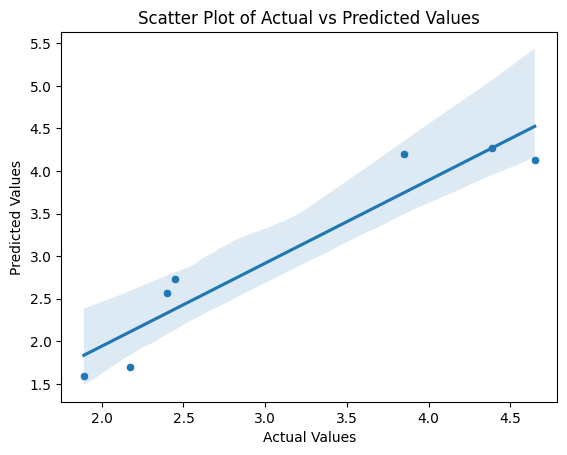

In [ ]:
# Create scatterplot for visual analysis
sns.scatterplot(x=labels_testing, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')


# Add regression line for qualitative analysis
sns.regplot(x=labels_testing, y=predictions, scatter=False)
plt.show()

The regression line attempts to minimize the distance between the actual and predicted values. The shaded region represents the confidence interval of the regression line.

In [ ]:
# 3 Features
# Uses the GDP, Unemployment, and Inflation of the last 11 months to predict the yield of return of the 12th month for every year

# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_GDP_Unemployment_Inflation_2d, Y_set, test_size=0.2, random_state=42)

model_LR = LinearRegression()
model_LR.fit(training_feature_matrix, labels_training)

predictions = model_LR.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)

predictions = model_LR.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Mean Squared Error for Training: 3.926524432618338e-24
Mean Squared Error for Testing: 34.088384289495046


In [ ]:
# 1 Feature
# Uses the Yield of the last 11 months to predict the yield of return of the 12th month for every year

# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_Yield_2d, Y_set, test_size=0.2, random_state=42)

model_LR = LinearRegression()
model_LR.fit(training_feature_matrix, labels_training)

predictions = model_LR.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)


predictions = model_LR.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Mean Squared Error for Training: 0.035240000566539115
Mean Squared Error for Testing: 0.12160425647042825


In [ ]:
# 1 Feature
# Uses the GDP of the last 11 months to predict the yield of return of the 12th month for every year

# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_GDP_2d, Y_set, test_size=0.2, random_state=42)

model_LR = LinearRegression()
model_LR.fit(training_feature_matrix, labels_training)

predictions = model_LR.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)


predictions = model_LR.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Mean Squared Error for Training: 1.1058511439626781
Mean Squared Error for Testing: 1.2787695695563401


In [ ]:
# 1 Feature
# Uses the Unemployment of the last 11 months to predict the yield of return of the 12th month for every year

# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_Unemployment_2d, Y_set, test_size=0.2, random_state=42)

model_LR = LinearRegression()
model_LR.fit(training_feature_matrix, labels_training)

predictions = model_LR.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)


predictions = model_LR.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Mean Squared Error for Training: 1.4602424873594566
Mean Squared Error for Testing: 11.740001064053393


In [ ]:
# 1 Feature
# Uses the Inflation of the last 11 months to predict the yield of return of the 12th month for every year

# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_Inflation_2d, Y_set, test_size=0.2, random_state=42)

model_LR = LinearRegression()
model_LR.fit(training_feature_matrix, labels_training)

predictions = model_LR.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)


predictions = model_LR.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)


Mean Squared Error for Training: 0.5421185179045603
Mean Squared Error for Testing: 2.26197190097239


##Model 2: RNN (LSTM)

In [ ]:
# 4 Features
# Uses the Yield of Return, GDP, Unemployment, and Inflation of the last 11 months to predict the yield of return of the 12th month for every year
# LSTM

model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, input_shape=np.shape(X_set[0])),
    tf.keras.layers.Dense(1)
])

# Create Optimizer and Learning Rate
learning_rate = .01
optimizer = SGD(learning_rate=learning_rate)

model_LSTM.compile(optimizer=optimizer, loss='mse')

In [ ]:
# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_set, Y_set, test_size=0.2, random_state=42)

model_LSTM.fit(training_feature_matrix, labels_training, epochs=10)

predictions = model_LSTM.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)

predictions = model_LSTM.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 19.2427
Epoch 2/10
1/1 [==============================] - 0s 30ms/step - loss: 16.2915
Epoch 3/10
1/1 [==============================] - 0s 23ms/step - loss: 13.9009
Epoch 4/10
1/1 [==============================] - 0s 23ms/step - loss: 11.9646
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 10.3962
Epoch 6/10
1/1 [==============================] - 0s 24ms/step - loss: 9.1257
Epoch 7/10
1/1 [==============================] - 0s 43ms/step - loss: 8.0967
Epoch 8/10
1/1 [==============================] - 0s 29ms/step - loss: 7.2632
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 6.5880
Epoch 10/10
1/1 [==============================] - 1s 1s/step
Mean Squared Error for Training: 5.598161479836788
1/1 [==============================] - 0s 40ms/step
Mean Squared Error for Testing: 1.1371752202592724


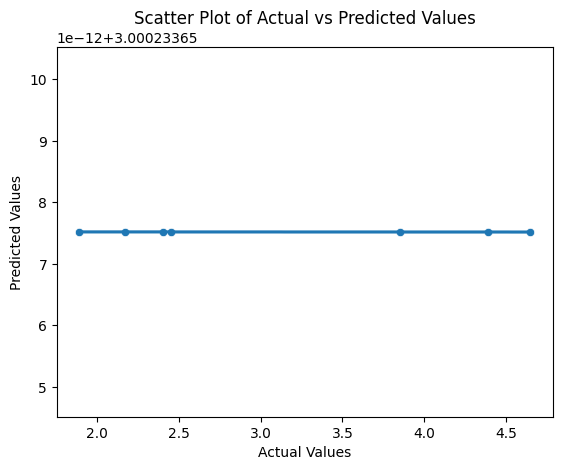

In [ ]:
sns.scatterplot(x=labels_testing, y=predictions.reshape(-1))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')

# Add regression line
sns.regplot(x=labels_testing, y=predictions, scatter=False)
plt.show()

In [ ]:
# 3 Features
# Uses the Yield of Return, GDP, and Unemployment of the last 11 months to predict the yield of return of the 12th month for every year
# LSTM

model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, input_shape=np.shape(X_Yield_GDP_Unemployment[0])),
    tf.keras.layers.Dense(1)
])

# Create Optimizer and Learning Rate
learning_rate = .01
optimizer = SGD(learning_rate=learning_rate)

model_LSTM.compile(optimizer=optimizer, loss='mse')

In [ ]:
# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_Yield_GDP_Unemployment, Y_set, test_size=0.2, random_state=42)

model_LSTM.fit(training_feature_matrix, labels_training, epochs=10)

predictions = model_LSTM.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)

predictions = model_LSTM.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 22.5153
Epoch 2/10
1/1 [==============================] - 0s 13ms/step - loss: 19.8071
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 17.4890
Epoch 4/10
1/1 [==============================] - 0s 16ms/step - loss: 15.5046
Epoch 5/10
1/1 [==============================] - 0s 15ms/step - loss: 13.8061
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 12.3521
Epoch 7/10
1/1 [==============================] - 0s 16ms/step - loss: 11.1075
Epoch 8/10
1/1 [==============================] - 0s 16ms/step - loss: 10.0422
Epoch 9/10
1/1 [==============================] - 0s 15ms/step - loss: 9.1303
Epoch 10/10
1/1 [==============================] - 0s 15ms/step - loss: 8.3497


1/1 [==============================] - 0s 446ms/step
Mean Squared Error for Training: 7.68147669028092
1/1 [==============================] - 0s 23ms/step
Mean Squared Error for Testing: 1.661121276651279


In [ ]:
# 3 Features
# Uses the Yield of Return, Unemployment, and Inflation of the last 11 months to predict the yield of return of the 12th month for every year
# LSTM

model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, input_shape=np.shape(X_Yield_Unemployment_Inflation[0])),
    tf.keras.layers.Dense(1)
])

# Create Optimizer and Learning Rate
learning_rate = .01
optimizer = SGD(learning_rate=learning_rate)

model_LSTM.compile(optimizer=optimizer, loss='mse')

In [ ]:
# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_Yield_Unemployment_Inflation, Y_set, test_size=0.2, random_state=42)

model_LSTM.fit(training_feature_matrix, labels_training, epochs=10)

predictions = model_LSTM.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)

predictions = model_LSTM.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 25.3550
Epoch 2/10
1/1 [==============================] - 0s 15ms/step - loss: 22.7050
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 20.3793
Epoch 4/10
1/1 [==============================] - 0s 17ms/step - loss: 18.3382
Epoch 5/10
1/1 [==============================] - 0s 17ms/step - loss: 16.5467
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 14.9741
Epoch 7/10
1/1 [==============================] - 0s 16ms/step - loss: 13.5928
Epoch 8/10
1/1 [==============================] - 0s 15ms/step - loss: 12.3746
Epoch 9/10
1/1 [==============================] - 0s 14ms/step - loss: 11.1665
Epoch 10/10
1/1 [==============================] - 0s 20ms/step - loss: 9.7262


1/1 [==============================] - 0s 466ms/step
Mean Squared Error for Training: 8.895505832651828
1/1 [==============================] - 0s 22ms/step
Mean Squared Error for Testing: 2.1586125374687963


In [ ]:
# 3 Features
# Uses the GDP, Unemployment, and Inflation of the last 11 months to predict the yield of return of the 12th month for every year
# LSTM

model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, input_shape=np.shape(X_GDP_Unemployment_Inflation[0])),
    tf.keras.layers.Dense(1)
])

# Create Optimizer and Learning Rate
learning_rate = .01
optimizer = SGD(learning_rate=learning_rate)

model_LSTM.compile(optimizer=optimizer, loss='mse')

In [ ]:
# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_GDP_Unemployment_Inflation, Y_set, test_size=0.2, random_state=42)

model_LSTM.fit(training_feature_matrix, labels_training, epochs=10)

predictions = model_LSTM.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)


predictions = model_LSTM.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 29.4990
Epoch 2/10
1/1 [==============================] - 0s 16ms/step - loss: 26.9061
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 24.5740
Epoch 4/10
1/1 [==============================] - 0s 19ms/step - loss: 22.4764
Epoch 5/10
1/1 [==============================] - 0s 26ms/step - loss: 20.5896
Epoch 6/10
1/1 [==============================] - 0s 22ms/step - loss: 18.8925
Epoch 7/10
1/1 [==============================] - 0s 25ms/step - loss: 17.3661
Epoch 8/10
1/1 [==============================] - 0s 17ms/step - loss: 15.9931
Epoch 9/10
1/1 [==============================] - 0s 25ms/step - loss: 14.7581
Epoch 10/10
1/1 [==============================] - 2s 2s/step
Mean Squared Error for Training: 12.648212792162221
1/1 [==============================] - 0s 113ms/step
Mean Squared Error for Testing: 4.115596357698094


In [ ]:
# 3 Features
# Uses the Yield of the last 11 months to predict the yield of return of the 12th month for every year
# LSTM
model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, input_shape=np.shape(X_Yield[0])),
    tf.keras.layers.Dense(1)
])

# Create Optimizer and Learning Rate
learning_rate = .01
optimizer = SGD(learning_rate=learning_rate)

model_LSTM.compile(optimizer=optimizer, loss='mse')

In [ ]:
# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_Yield, Y_set, test_size=0.2, random_state=42)

model_LSTM.fit(training_feature_matrix, labels_training, epochs=10)

predictions = model_LSTM.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)


predictions = model_LSTM.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 25.5283
Epoch 2/10
1/1 [==============================] - 0s 21ms/step - loss: 21.3995
Epoch 3/10
1/1 [==============================] - 0s 21ms/step - loss: 18.4147
Epoch 4/10
1/1 [==============================] - 0s 23ms/step - loss: 15.8788
Epoch 5/10
1/1 [==============================] - 0s 26ms/step - loss: 13.6776
Epoch 6/10
1/1 [==============================] - 0s 22ms/step - loss: 11.7756
Epoch 7/10
1/1 [==============================] - 0s 25ms/step - loss: 10.1507
Epoch 8/10
1/1 [==============================] - 0s 27ms/step - loss: 8.7751
Epoch 9/10
1/1 [==============================] - 0s 23ms/step - loss: 7.6128
Epoch 10/10
1/1 [==============================] - 1s 1s/step
Mean Squared Error for Training: 5.797707754771767
1/1 [==============================] - 0s 35ms/step
Mean Squared Error for Testing: 1.2482331395726904


In [ ]:
# 1 Feature
# Uses the GDP of the last 11 months to predict the yield of return of the 12th month for every year
# LSTM
model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, input_shape=np.shape(X_GDP[0])),
    tf.keras.layers.Dense(1)
])

# Create Optimizer and Learning Rate
learning_rate = .01
optimizer = SGD(learning_rate=learning_rate)

model_LSTM.compile(optimizer=optimizer, loss='mse')

In [ ]:
# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_GDP, Y_set, test_size=0.2, random_state=42)

model_LSTM.fit(training_feature_matrix, labels_training, epochs=10)

predictions = model_LSTM.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)


predictions = model_LSTM.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 21.6016
Epoch 2/10
1/1 [==============================] - 0s 18ms/step - loss: 18.3690
Epoch 3/10
1/1 [==============================] - 0s 17ms/step - loss: 15.7213
Epoch 4/10
1/1 [==============================] - 0s 13ms/step - loss: 13.5518
Epoch 5/10
1/1 [==============================] - 0s 13ms/step - loss: 11.7742
Epoch 6/10
1/1 [==============================] - 0s 16ms/step - loss: 10.3176
Epoch 7/10
1/1 [==============================] - 0s 16ms/step - loss: 9.1241
Epoch 8/10
1/1 [==============================] - 0s 15ms/step - loss: 8.1462
Epoch 9/10
1/1 [==============================] - 0s 17ms/step - loss: 7.3449
Epoch 10/10
1/1 [==============================] - 1s 633ms/step
Mean Squared Error for Training: 6.1503300487348325
1/1 [==============================] - 0s 36ms/step
Mean Squared Error for Testing: 1.2154262528002264


In [ ]:
# 1 Feature
# Uses the Unemployment of the last 11 months to predict the yield of return of the 12th month for every year
# LSTM
model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, input_shape=np.shape(X_Unemployment[0])),
    tf.keras.layers.Dense(1)
])

# Create Optimizer and Learning Rate
learning_rate = .01
optimizer = SGD(learning_rate=learning_rate)

model_LSTM.compile(optimizer=optimizer, loss='mse')

In [ ]:
# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_Unemployment, Y_set, test_size=0.2, random_state=42)

model_LSTM.fit(training_feature_matrix, labels_training, epochs=10)

predictions = model_LSTM.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)


predictions = model_LSTM.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 12.3544
Epoch 2/10
1/1 [==============================] - 0s 20ms/step - loss: 9.5426
Epoch 3/10
1/1 [==============================] - 0s 20ms/step - loss: 7.9793
Epoch 4/10
1/1 [==============================] - 0s 23ms/step - loss: 6.8606
Epoch 5/10
1/1 [==============================] - 0s 19ms/step - loss: 6.0394
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 5.4341
Epoch 7/10
1/1 [==============================] - 0s 15ms/step - loss: 4.9866
Epoch 8/10
1/1 [==============================] - 0s 14ms/step - loss: 4.6546
Epoch 9/10
1/1 [==============================] - 0s 22ms/step - loss: 4.4071
Epoch 10/10
1/1 [==============================] - 1s 696ms/step
Mean Squared Error for Training: 4.0830411436951906
1/1 [==============================] - 0s 38ms/step
Mean Squared Error for Testing: 1.6515903687704194


In [ ]:
# 1 Feature
# Uses the Inflation of the last 11 months to predict the yield of return of the 12th month for every year
# LSTM
model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, input_shape=np.shape(X_Inflation[0])),
    tf.keras.layers.Dense(1)
])

# Create Optimizer and Learning Rate
learning_rate = .01
optimizer = SGD(learning_rate=learning_rate)

model_LSTM.compile(optimizer=optimizer, loss='mse')

In [ ]:
# Split data into training and testing
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_Inflation, Y_set, test_size=0.2, random_state=42)

model_LSTM.fit(training_feature_matrix, labels_training, epochs=10)

predictions = model_LSTM.predict(training_feature_matrix)
mse = mean_squared_error(labels_training, predictions)
print("Mean Squared Error for Training:", mse)


predictions = model_LSTM.predict(testing_feature_matrix)
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 30.1242
Epoch 2/10
1/1 [==============================] - 0s 17ms/step - loss: 21.5369
Epoch 3/10
1/1 [==============================] - 0s 26ms/step - loss: 20.1392
Epoch 4/10
1/1 [==============================] - 0s 27ms/step - loss: 18.8511
Epoch 5/10
1/1 [==============================] - 0s 25ms/step - loss: 17.6640
Epoch 6/10
1/1 [==============================] - 0s 31ms/step - loss: 16.5700
Epoch 7/10
1/1 [==============================] - 0s 22ms/step - loss: 15.5618
Epoch 8/10
1/1 [==============================] - 0s 34ms/step - loss: 14.6326
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 13.7762
Epoch 10/10
1/1 [==============================] - 1s 780ms/step
Mean Squared Error for Training: 12.2596682186709
1/1 [==============================] - 0s 44ms/step
Mean Squared Error for Testing: 3.892640984105509


##Model 3: ARIMA

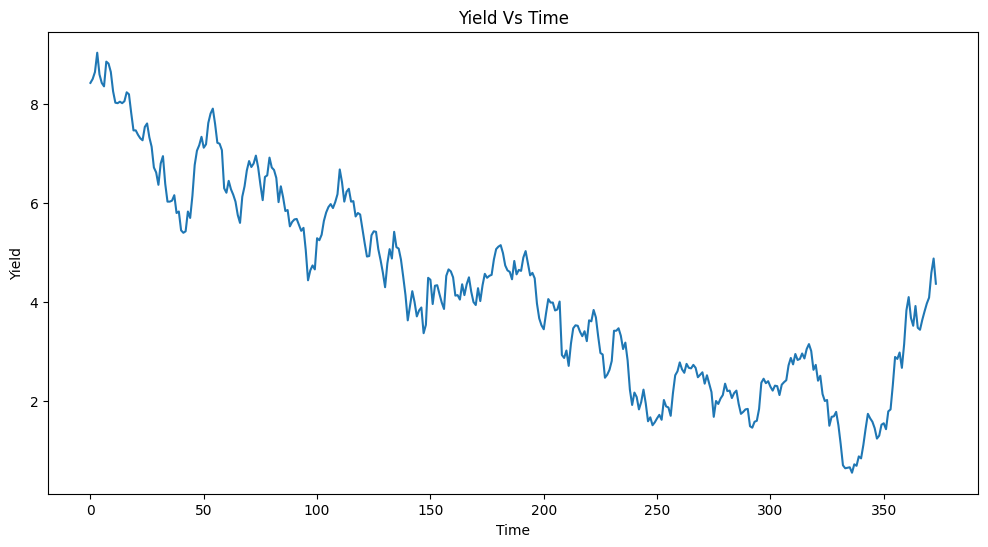

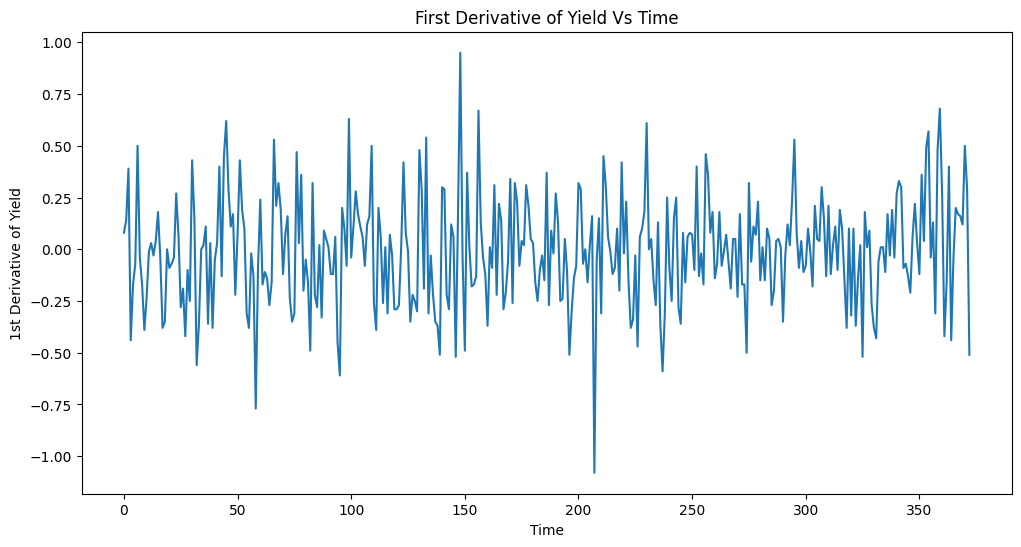

In [ ]:
# Hyper Parameter Analysis for ARIMA
# Plots the Yield Data and the First Derivative of the Yield Data
yield_data = X_set[:, :, 0].flatten()
plt.figure(figsize=(12,6))
plt.title("Yield Vs Time")
plt.xlabel("Time")
plt.ylabel("Yield")
plt.plot(yield_data)

diff_1_yield = np.diff(yield_data)
plt.figure(figsize=(12,6))
plt.title("First Derivative of Yield Vs Time")
plt.xlabel("Time")
plt.ylabel("1st Derivative of Yield")
plt.plot(diff_1_yield)

In [ ]:
# Hyper Parameter Analysis for ARIMA
# Does the Augmented Dickey-Fuller (ADF) Test on the Yield Data and the First Derivative of the Yield Data
# Test for Stationarity(Constant Mean and Variance over Time)
# If p-value less than 0.05 we can determine the data has Stationary
adf_test = adfuller(yield_data)
print('ADF Statistic for Yield Data: %f' % adf_test[0])
print('p-value for Yield Data: %f' % adf_test[1])

adf_test = adfuller(diff_1_yield)
print('ADF Statistic for 1st Derivative of Yield Data: %f' % adf_test[0])
print('p-value for 1st Derivative of Yield Data: %f' % adf_test[1])

ADF Statistic for Yield Data: -2.231895
p-value for Yield Data: 0.194874
ADF Statistic for 1st Derivative of Yield Data: -17.214133
p-value for 1st Derivative of Yield Data: 0.000000


<Figure size 1200x600 with 0 Axes>

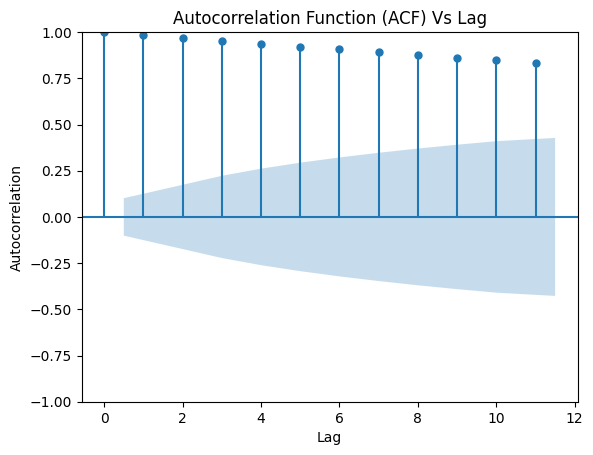

<Figure size 1200x600 with 0 Axes>

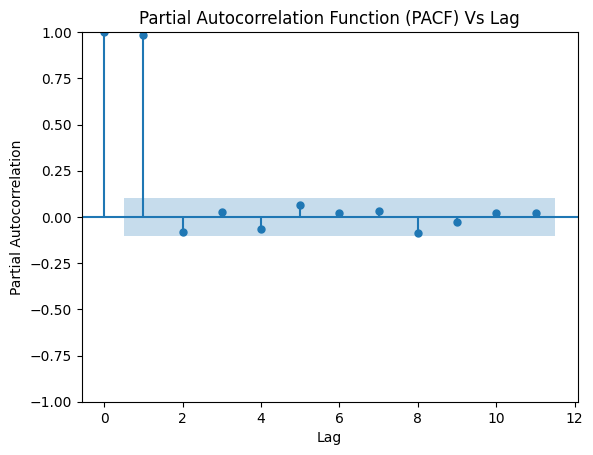

In [ ]:
# Hyper Parameter Analysis for ARIMA
# Uses Autocorrelation Function(ACF) and Partial Autocorrelation Function(PACF) to find the right q and p values
# To find the p and q values you look at the figures and determine where the lag has a sudden drop, the lag before the sudden drop is your p and q values
plt.figure(figsize=(12,6))
plot_acf(yield_data, lags = 11)
plt.title('Autocorrelation Function (ACF) Vs Lag')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(12,6))
plot_pacf(yield_data, lags = 11)
plt.title('Partial Autocorrelation Function (PACF) Vs Lag')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [ ]:
# Training and Running ARIMA
X_Yield_ARIMA_Data = X_Yield.reshape(len(X_Yield), -1)
predictions = np.zeros(len(X_set))
for i in range(len(X_Yield_ARIMA_Data)):

    sequence = X_Yield_ARIMA_Data[i]

    # Fit ARIMA model to the first 11 values of the sequence
    # Order is in p, d, q
    model_ARIMA = ARIMA(sequence, order=(1, 1, 0))
    model_ARIMA = model_ARIMA.fit()

    # Make prediction for the 12th value
    prediction = model_ARIMA.forecast(steps=1)[0]
    predictions[i] = prediction


mse = mean_squared_error(Y_set, predictions)
print("Mean Squared Error for Testing:", mse)

Mean Squared Error for Testing: 0.11189099492838134


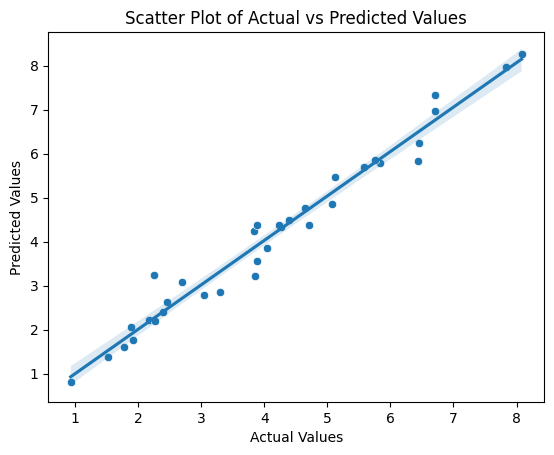

In [ ]:
sns.scatterplot(x=Y_set, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')

# Add regression line
sns.regplot(x=Y_set, y=predictions, scatter=False)
plt.show()

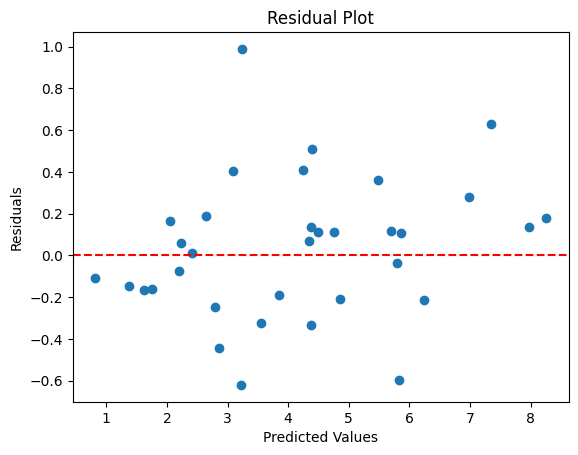

In [ ]:
# Creating residual plot

residuals = predictions - Y_set

plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [ ]:
# Training and Running ARIMA
X_Yield_ARIMA_Data = X_Yield.reshape(len(X_Yield), -1)
predictions = np.zeros(len(X_set))
for i in range(len(X_Yield_ARIMA_Data)):

    sequence = X_Yield_ARIMA_Data[i]

    # Fit ARIMA model to the first 11 values of the sequence
    # Order is in p, d, q
    model_ARIMA = ARIMA(sequence, order=(1, 1, 1))
    model_ARIMA = model_ARIMA.fit()

    # Make prediction for the 12th value
    prediction = model_ARIMA.forecast(steps=1)[0]
    predictions[i] = prediction


mse = mean_squared_error(Y_set, predictions)
print("Mean Squared Error for Testing:", mse)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error for Testing: 0.1180663635928868


##Model 4: Random Forest Regression

In [ ]:
# 4 features

# Split data into training and testing (80% for training, 20% for testing)
training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_set_2d, Y_set, test_size=0.2, random_state=42)

# Creating and fitting RandomForest Model
rf_regressor = RandomForestRegressor(random_state=25) #
rf_regressor.fit(training_feature_matrix, labels_training)

# Making predictions
predictions = rf_regressor.predict(testing_feature_matrix)

# Find MSE
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Mean Squared Error for Testing: 0.3511305199999994


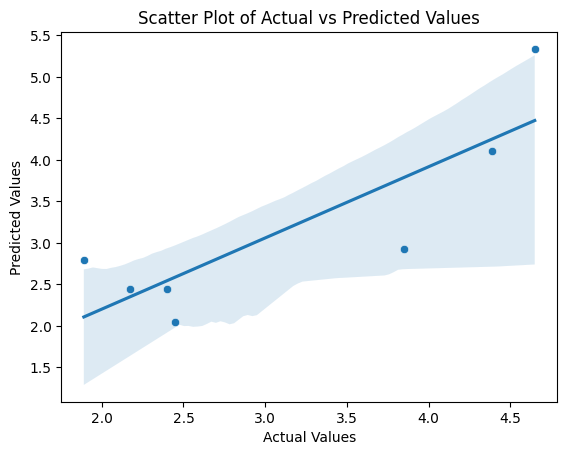

In [ ]:
# Create scatterplot for visual analysis
sns.scatterplot(x=labels_testing, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')


# Add regression line for qualitative analysis
sns.regplot(x=labels_testing, y=predictions, scatter=False)
plt.show()

Since this has a large shaded region, we can conclude that there is more uncertainty in this model.

In [ ]:
# Model predictions using 3 of the features

training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_Yield_GDP_Unemployment_2d, Y_set, test_size=0.2, random_state=42)

# Creating and fitting RandomForest Model
rf_regressor = RandomForestRegressor(random_state=25)
rf_regressor.fit(training_feature_matrix, labels_training)


# Making predictions
predictions = rf_regressor.predict(testing_feature_matrix)

# Find MSE
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)


Mean Squared Error for Testing: 0.347456774285714


In [ ]:
# Model predictions using 3 of the features

training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_Yield_Unemployment_Inflation_2d, Y_set, test_size=0.2, random_state=42)

# Creating and fitting RandomForest Model
rf_regressor = RandomForestRegressor(random_state=25)
rf_regressor.fit(training_feature_matrix, labels_training)


# Making predictions
predictions = rf_regressor.predict(testing_feature_matrix)

# Find MSE
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Mean Squared Error for Testing: 0.3181930299999998


In [ ]:
# Model predictions using 3 of the features

training_feature_matrix, testing_feature_matrix, labels_training, labels_testing = train_test_split(X_GDP_Unemployment_Inflation_2d, Y_set, test_size=0.2, random_state=42)

# Creating and fitting RandomForest Model
rf_regressor = RandomForestRegressor(random_state=25)
rf_regressor.fit(training_feature_matrix, labels_training)


# Making predictions
predictions = rf_regressor.predict(testing_feature_matrix)

# Find MSE
mse = mean_squared_error(labels_testing, predictions)
print("Mean Squared Error for Testing:", mse)

Mean Squared Error for Testing: 0.35943430428571327
